In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [21]:
import imp
imp.reload(xy)

<module 'xy' from 'E:\\PyProject\\factors\\KURs\\xy.py'>

In [ ]:
import xy

# $因子描述：成交量波峰因子（Kurtosis）$

***计算标的每天前230分钟当中的成交量峰值个数，识别短期内多次放量的行为。***
即日内出现“放量”现象越多的标的可能有更多的趋势交易者或知情交易者参与，进而有更高的概率在未来获得更高收益。

1. 数据：标的分钟行情（**对于指数因子，此处采用指数ETF分钟行情**）  
2. 定义每日成交量波峰，同时满足下列两个条件：  
    条件1：分钟成交量 - mean > k * std  
    条件2：**前一个分钟成交量与条件1互斥**   
3. 数每日波峰的数量

$参考报告：《20201012-长江证券-基础因子研究（十四）：高频因子（九），高频波动中的时间序列信息》$

![示例](sample.jpg)

## 计算

In [3]:
def shift_post1(arr, num):
    result = np.empty_like(arr)
    result[:,0:num] = False
    result[:,num:] = arr[:,:-num]

    return result

def shift_nag1(arr, num):
    result = np.empty_like(arr)
    result[:,-num:] = False
    result[:,:-num] = arr[:,num:]

    return result

def index_kur_ex10_s(apd, k, rt):
    apd.index = apd.index.map(lambda x:str(x)[:10])
    # 排除最后十分钟
    win = xy.rolling_window(apd,230)
    win2 = xy.rolling_window(rt,230)
    
    m = win[::240].mean(axis=1)
    mean = np.tile(m.reshape(-1,1),(1,230))
    std = win[::240].std(axis=1)
    st_d = np.tile(std.reshape(-1,1),(1,230))

    logi = win[::240] - mean > k*st_d
    logi1 = win[::240] - mean <= k*st_d
    logi1[:,119] = True
    
    rt.index = rt.index.map(lambda x:str(x)[:10])
    logi2 = win2[::240] >= 0.000


    kur_up = np.nansum(np.where((logi & shift_nag1(logi1,1) & logi2), 1,np.nan),axis = 1)
    kur = kur_up 

    kurs = pd.Series(kur, index = apd.index[239::240], name = 'kurs')
    return kurs

In [23]:
xy.ETFMin50jq

,open,close,high,low,volume,money
2009-01-05 09:31:00,0.926,0.928,0.930,0.926,9873138,11062071
2009-01-05 09:32:00,0.928,0.929,0.929,0.928,6785780,7617732
2009-01-05 09:33:00,0.928,0.928,0.928,0.926,10095366,11320030
2009-01-05 09:34:00,0.927,0.926,0.927,0.926,4908014,5498664
2009-01-05 09:35:00,0.926,0.925,0.926,0.925,3493079,3910239
...,...,...,...,...,...,...
2023-08-28 14:56:00,2.597,2.596,2.598,2.596,15976900,41484423
2023-08-28 14:57:00,2.595,2.595,2.596,2.594,10268100,26647472
2023-08-28 14:58:00,2.594,2.597,2.597,2.594,1938700,5033038
2023-08-28 14:59:00,2.596,2.595,2.597,2.594,7711900,20012850


In [24]:
# 参数平滑
ETFKURScountjq_s01 = pd.concat([
    index_kur_ex10_s(xy.ETFMin50jq.loc['2016-01-28':].volume,0.1,xy.ETFMin50jq.loc['2016-01-28':].close.pct_change()).rename('50'),
    index_kur_ex10_s(xy.ETFMin300jq.loc['2016-01-28':].volume,0.1,xy.ETFMin300jq.loc['2016-01-28':].close.pct_change()).rename('300'),
    index_kur_ex10_s(xy.ETFMin500jq.loc['2016-01-28':].volume,0.1,xy.ETFMin500jq.loc['2016-01-28':].close.pct_change()).rename('500'),
    index_kur_ex10_s(xy.ETFMin1000jq.loc['2016-01-28':].volume,0.1,xy.ETFMin1000jq.loc['2016-01-28':].close.pct_change()).rename('1000'),
    index_kur_ex10_s(xy.ETFMin100sz_jq.loc['2016-01-28':].volume,0.1,xy.ETFMin100sz_jq.loc['2016-01-28':].close.pct_change()).rename('100sz'),
    index_kur_ex10_s(xy.ETFMin50kc_jq.loc['2016-01-28':].volume,0.1,xy.ETFMin50kc_jq.loc['2016-01-28':].close.pct_change()).rename('50kc'),
    index_kur_ex10_s(xy.ETFMin2000jq.loc['2016-01-28':].volume,0.1,xy.ETFMin2000jq.loc['2016-01-28':].close.pct_change()).rename('2000')
],axis=1).shift(1)

ETFKURScountjq_s02 = pd.concat([
    index_kur_ex10_s(xy.ETFMin50jq.loc['2016-01-28':].volume,0.2,xy.ETFMin50jq.loc['2016-01-28':].close.pct_change()).rename('50'),
    index_kur_ex10_s(xy.ETFMin300jq.loc['2016-01-28':].volume,0.2,xy.ETFMin300jq.loc['2016-01-28':].close.pct_change()).rename('300'),
    index_kur_ex10_s(xy.ETFMin500jq.loc['2016-01-28':].volume,0.2,xy.ETFMin500jq.loc['2016-01-28':].close.pct_change()).rename('500'),
    index_kur_ex10_s(xy.ETFMin1000jq.loc['2016-01-28':].volume,0.2,xy.ETFMin1000jq.loc['2016-01-28':].close.pct_change()).rename('1000'),
    index_kur_ex10_s(xy.ETFMin100sz_jq.loc['2016-01-28':].volume,0.2,xy.ETFMin100sz_jq.loc['2016-01-28':].close.pct_change()).rename('100sz'),
    index_kur_ex10_s(xy.ETFMin50kc_jq.loc['2016-01-28':].volume,0.2,xy.ETFMin50kc_jq.loc['2016-01-28':].close.pct_change()).rename('50kc'),
    index_kur_ex10_s(xy.ETFMin2000jq.loc['2016-01-28':].volume,0.2,xy.ETFMin2000jq.loc['2016-01-28':].close.pct_change()).rename('2000')
],axis=1).shift(1)

ETFKURScountjq_s03 = pd.concat([
    index_kur_ex10_s(xy.ETFMin50jq.loc['2016-01-28':].volume,0.3,xy.ETFMin50jq.loc['2016-01-28':].close.pct_change()).rename('50'),
    index_kur_ex10_s(xy.ETFMin300jq.loc['2016-01-28':].volume,0.3,xy.ETFMin300jq.loc['2016-01-28':].close.pct_change()).rename('300'),
    index_kur_ex10_s(xy.ETFMin500jq.loc['2016-01-28':].volume,0.3,xy.ETFMin500jq.loc['2016-01-28':].close.pct_change()).rename('500'),
    index_kur_ex10_s(xy.ETFMin1000jq.loc['2016-01-28':].volume,0.3,xy.ETFMin1000jq.loc['2016-01-28':].close.pct_change()).rename('1000'),
    index_kur_ex10_s(xy.ETFMin100sz_jq.loc['2016-01-28':].volume,0.3,xy.ETFMin100sz_jq.loc['2016-01-28':].close.pct_change()).rename('100sz'),
    index_kur_ex10_s(xy.ETFMin50kc_jq.loc['2016-01-28':].volume,0.3,xy.ETFMin50kc_jq.loc['2016-01-28':].close.pct_change()).rename('50kc'),
    index_kur_ex10_s(xy.ETFMin2000jq.loc['2016-01-28':].volume,0.3,xy.ETFMin2000jq.loc['2016-01-28':].close.pct_change()).rename('2000')
],axis=1).shift(1)

ETFKURScountjq_s04 = pd.concat([
    index_kur_ex10_s(xy.ETFMin50jq.loc['2016-01-28':].volume,0.4,xy.ETFMin50jq.loc['2016-01-28':].close.pct_change()).rename('50'),
    index_kur_ex10_s(xy.ETFMin300jq.loc['2016-01-28':].volume,0.4,xy.ETFMin300jq.loc['2016-01-28':].close.pct_change()).rename('300'),
    index_kur_ex10_s(xy.ETFMin500jq.loc['2016-01-28':].volume,0.4,xy.ETFMin500jq.loc['2016-01-28':].close.pct_change()).rename('500'),
    index_kur_ex10_s(xy.ETFMin1000jq.loc['2016-01-28':].volume,0.4,xy.ETFMin1000jq.loc['2016-01-28':].close.pct_change()).rename('1000'),
    index_kur_ex10_s(xy.ETFMin100sz_jq.loc['2016-01-28':].volume,0.4,xy.ETFMin100sz_jq.loc['2016-01-28':].close.pct_change()).rename('100sz'),
    index_kur_ex10_s(xy.ETFMin50kc_jq.loc['2016-01-28':].volume,0.4,xy.ETFMin50kc_jq.loc['2016-01-28':].close.pct_change()).rename('50kc'),
    index_kur_ex10_s(xy.ETFMin2000jq.loc['2016-01-28':].volume,0.4,xy.ETFMin2000jq.loc['2016-01-28':].close.pct_change()).rename('2000')
],axis=1).shift(1)

ETFKURScountjq_s = (ETFKURScountjq_s01+ETFKURScountjq_s02+ETFKURScountjq_s03+ETFKURScountjq_s04) / 4

## 评估

### cl-cl

In [29]:
xy._Standlize(ETFKURScountjq_s.T.loc[['50','300','500','1000'],'2016-01-06':])

,2016-01-28,2016-01-29,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-15,2016-02-16,2016-02-17,...,2023-08-15,2023-08-16,2023-08-17,2023-08-18,2023-08-21,2023-08-22,2023-08-23,2023-08-24,2023-08-25,2023-08-28
50,NaN,0.389364,0.459598,0.864021,0.725574,0.456977,0.263462,0.919803,0.898710,0.693055,...,0.390101,1.024695,-0.913927,0.648919,0.765169,-0.530699,-0.664414,-0.088235,0.053812,-0.864068
300,NaN,0.438807,0.772961,0.676643,0.796942,0.298028,0.237116,0.742491,0.117223,0.791361,...,-0.875091,-1.317465,-0.754983,-1.247922,-1.103036,-0.922600,0.117250,-1.382353,-1.022432,-0.370315
500,NaN,0.661301,0.229799,-0.218608,-0.178420,0.721891,0.922118,-0.498688,0.403768,-0.113052,...,-0.748572,0.439155,0.516568,-0.349418,-0.586298,0.089811,-0.820747,0.735294,-0.376685,-0.205731
1000,NaN,-1.489472,-1.462359,-1.322056,-1.344096,-1.476897,-1.422696,-1.163606,-1.419701,-1.371365,...,1.233562,-0.146385,1.152343,0.948421,0.924165,1.363489,1.367911,0.735294,1.345305,1.440114


In [27]:
ETFKURScountjq_s

,50,300,500,1000,100sz,50kc,2000
2016-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-29,19.00,19.50,21.75,0.00,8.50,0.0,0.0
2016-02-01,23.00,26.75,20.25,0.00,19.50,0.0,0.0
2016-02-02,26.25,24.00,13.25,0.00,11.25,0.0,0.0
2016-02-03,21.75,22.50,12.25,0.00,21.75,0.0,0.0
...,...,...,...,...,...,...,...
2023-08-22,10.25,7.25,15.00,24.75,NaN,NaN,NaN
2023-08-23,10.50,13.00,10.00,17.00,NaN,NaN,NaN
2023-08-24,12.50,9.75,14.25,14.25,NaN,NaN,NaN
2023-08-25,15.75,13.25,14.75,18.75,NaN,NaN,NaN


0.05731725465305896
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

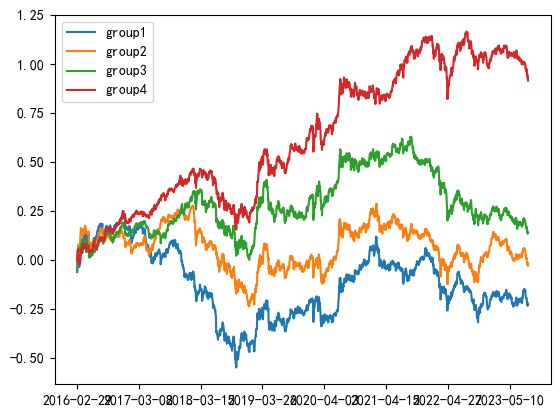

In [25]:
# 分组收益率
gr_kurs = xy.cal_rate_group(
    ETFKURScountjq_s.T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_kurs.cumsum().plot()

0.06735301254825386
1 0.9966044142614601
2 0.9966044142614601
3 0.9966044142614601
4 0.9966044142614601


<Axes: >

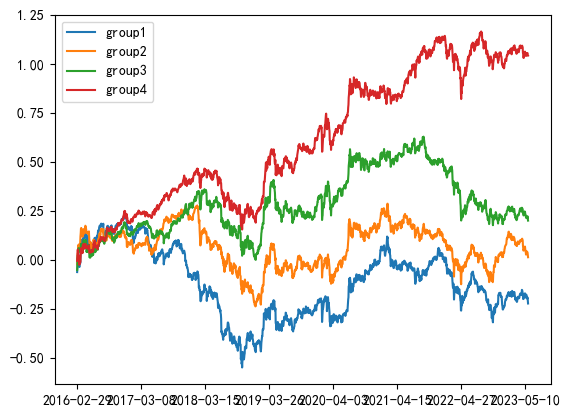

In [5]:
# 分组收益率
gr_kurs = xy.cal_rate_group(
    ETFKURScountjq_s.T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_kurs.cumsum().plot()

4008.0
yoy: 0.17334012711997146 
 mdd: -0.3162555289607656 
 sharpe: 1.152201729428883 
 rankIC: 0.02969186664045665 
 rankIR: 0.04635452163303041 
 win%: 0.5232621784345922 
 gain_loss%: -1.1212787372371438


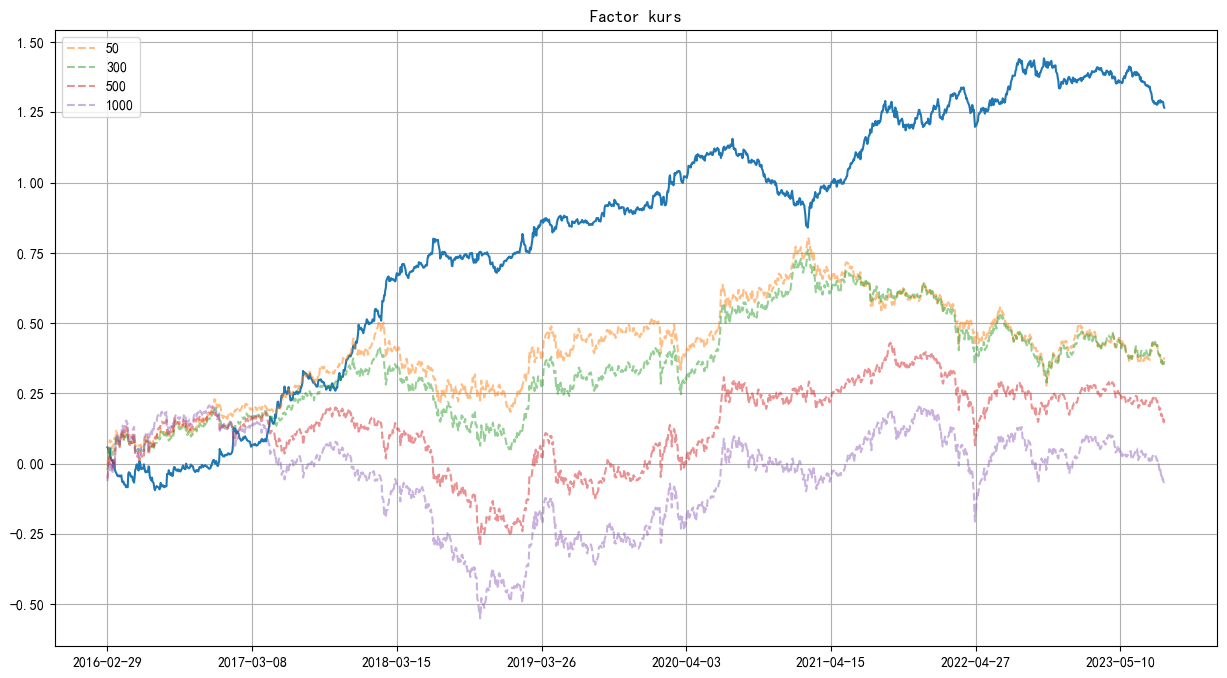

In [33]:
# 单因子强弱
KURScount_select, KURScount_rets = xy.single_Factor_backtest(
    ETFKURScountjq_s.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='kurs'
)

3850.0
yoy: 0.19598474736777644 
 mdd: -0.3162555289607656 
 sharpe: 1.2976454204759837 
 rankIC: 0.03595683933868232 
 rankIR: 0.05636728570771718 
 win%: 0.5245346869712352 
 gain_loss%: -1.130176494263907


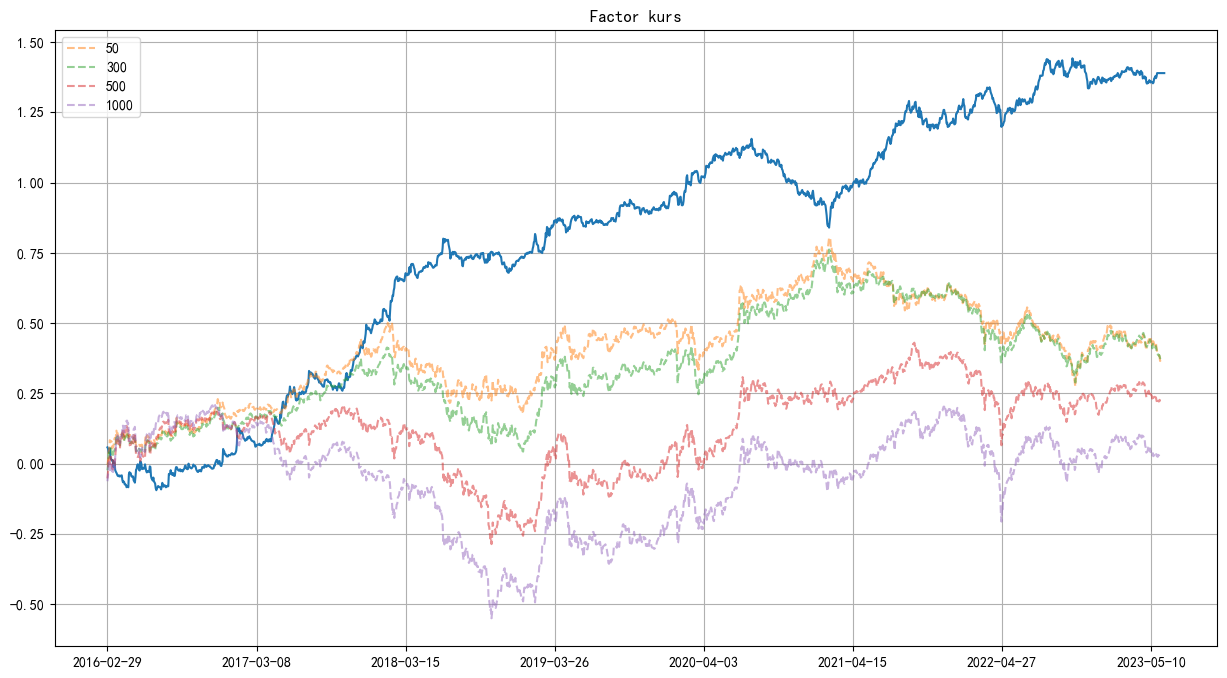

In [6]:
# 单因子强弱
KURScount_select, KURScount_rets = xy.single_Factor_backtest(
    ETFKURScountjq_s.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='kurs'
)

0.02969186664045665

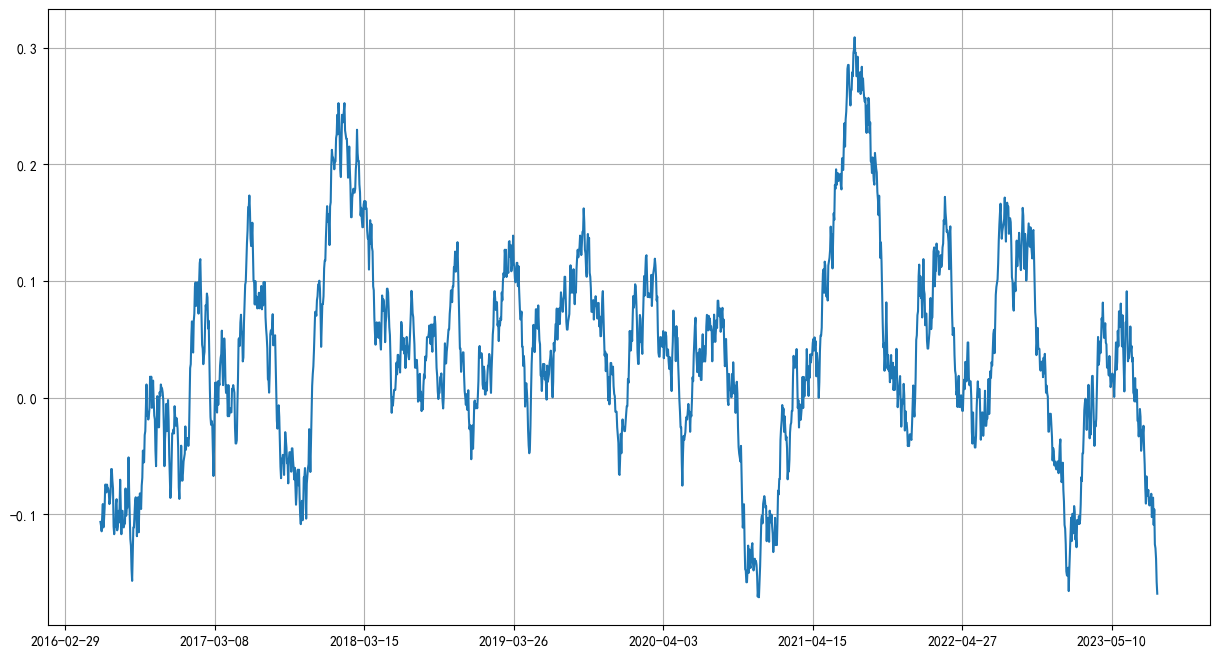

In [34]:
# 因子截面IC趋势
rankIC = xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(ETFKURScountjq_s.T.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### 择时

#### 多头

shrh: 0 win%: 0.535512256442489 gainloss%: -0.8508747522123308
shrh: 3 win%: 0.5373891001267427 gainloss%: -0.8494190092897735
shrh: 6 win%: 0.5385647216633133 gainloss%: -0.8552590227652718
shrh: 9 win%: 0.5425131677953349 gainloss%: -0.8509723026160321
shrh: 12 win%: 0.5425347222222222 gainloss%: -0.8801147521451184
shrh: 15 win%: 0.5398512221041445 gainloss%: -0.8757352028293245
shrh: 18 win%: 0.5472222222222223 gainloss%: -0.8775850090488254
shrh: 21 win%: 0.5496031746031746 gainloss%: -0.9630278416206371
shrh: 24 win%: 0.5484848484848485 gainloss%: -0.9102691421889711
shrh: 27 win%: 0.5668449197860963 gainloss%: -1.0639277234954334


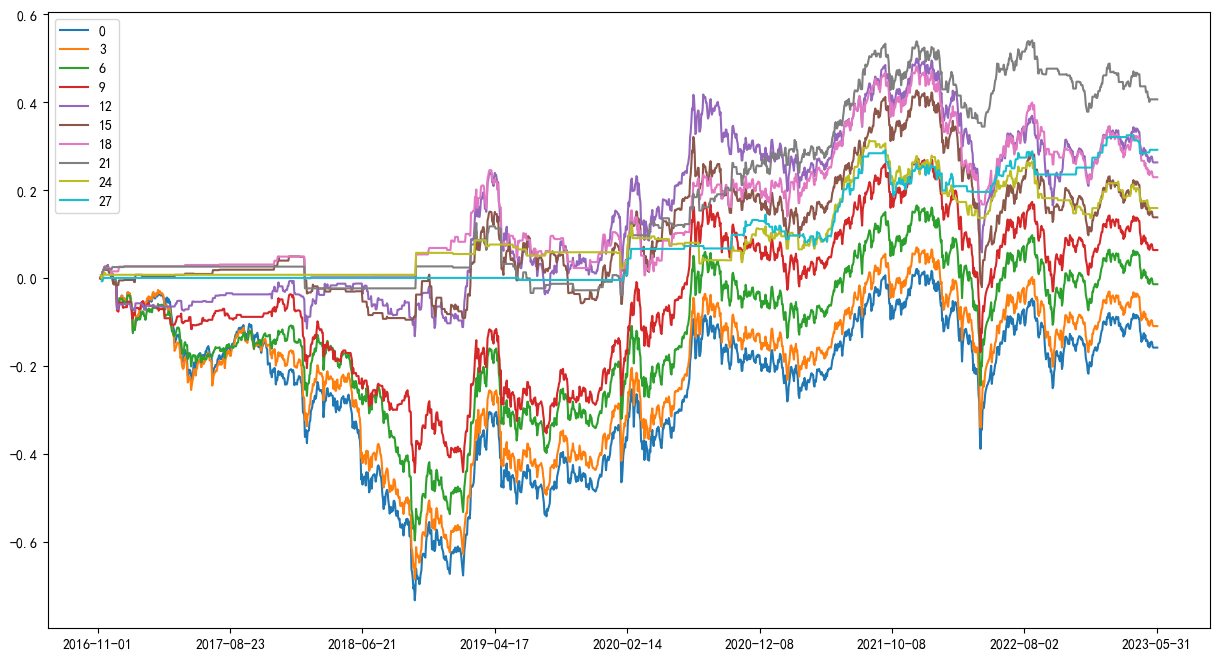

In [66]:
idx_name = '1000'
for i in range(30)[::3]:
    # i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(ETFKURScountjq_s[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[ETFKURScountjq_s[idx_name][ETFKURScountjq_s[idx_name]>i].index&same_dt]
    
    if len(ts_ret) < 1:
        continue

    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    
    pd.Series(ts_ret.cumsum().rename(i),xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))

#### 空头

In [ ]:
idx_name = '1000'
for i in range(30)[::3]:
    # i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(ETFKURScountjq_s[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[ETFKURScountjq_s[idx_name][ETFKURScountjq_s[idx_name]<-i].index&same_dt]
    
    # if len(ts_ret) < 1:
    #     continue
        
    win_pct = ts_ret[ts_ret<0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret<0].mean()/ts_ret[ts_ret>0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    
    pd.Series(ts_ret.cumsum().rename(i), xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))

ZeroDivisionError: division by zero

### cl_op

0.12593860888230676
1 0.9966044142614601
2 0.9966044142614601
3 0.9966044142614601
4 0.9966044142614601


<Axes: >

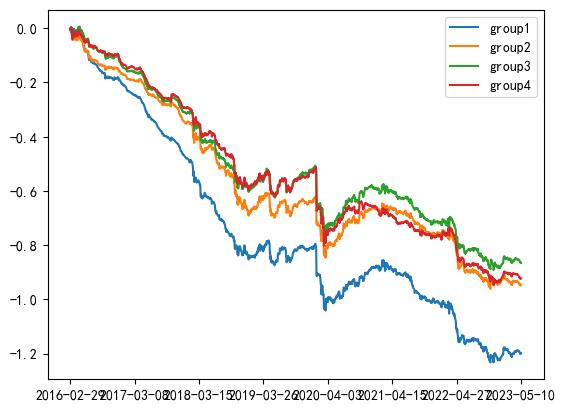

In [247]:
# 分组收益率
gr_kurs = xy.cal_rate_group(
    ETFKURScountjq_s.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_kurs.cumsum().plot()

3850.0
yoy: 0.037748406622726716 
 mdd: -0.1175367032696043 
 sharpe: 0.8687778129622482 
 rankIC: 0.0699718640086014 
 rankIR: 0.11269988821366834 
 win%: 0.5442752397067118 
 gain_loss%: -0.9730719222889005


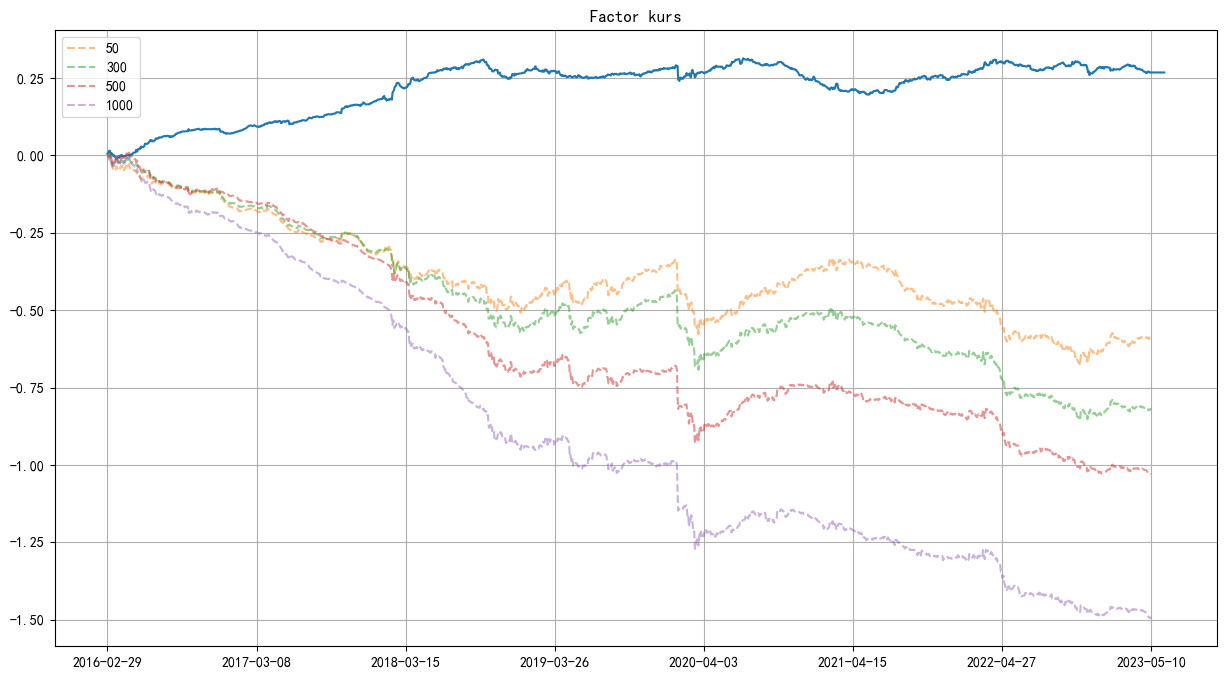

In [253]:
# 单因子强弱
KURScount_select, KURScount_rets = xy.single_Factor_backtest(
    ETFKURScountjq_s.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='kurs'
)

0.0699718640086014

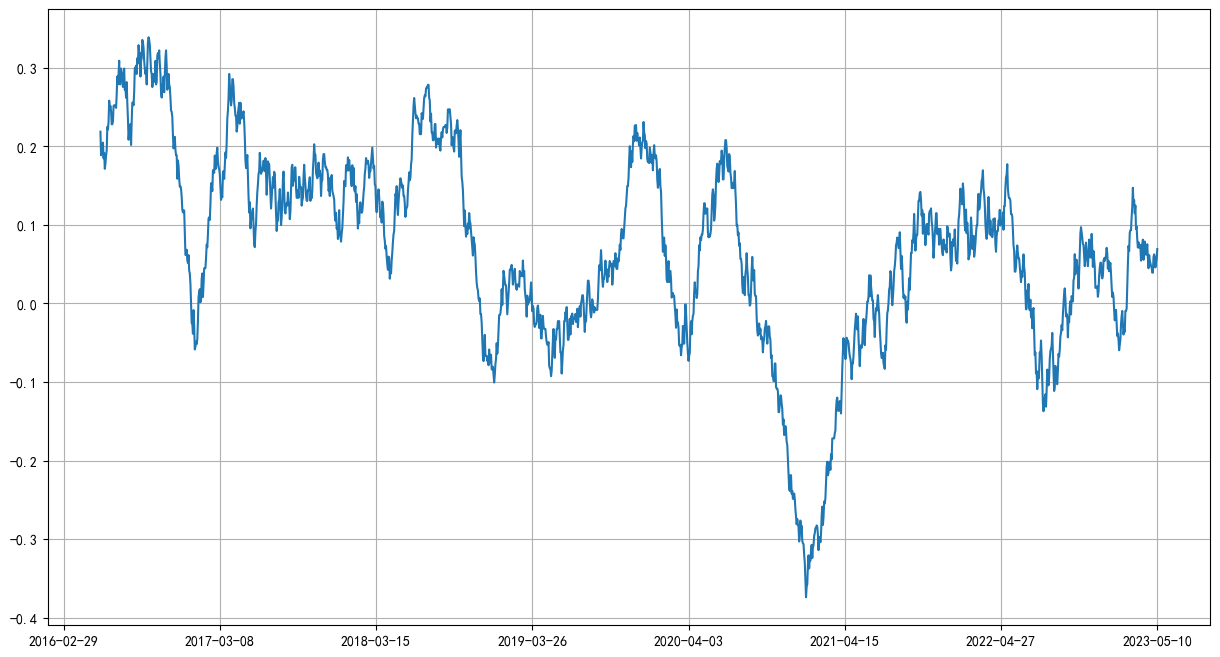

In [254]:
# 因子截面IC趋势
rankIC = xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(ETFKURScountjq_s.T.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

In [32]:
ETFKURScountjq_s.T.to_csv('../NewFactor/Kur_idxETF1.csv')